In [3]:
import camb
import numpy as np
from scipy import optimize
import matplotlib.pyplot as plt
import corner

In [4]:
from matplotlib import rcParams
rcParams['figure.figsize'] = (12,8)

In [5]:
#Gotta have that fall matplotlib aesthetic
c1 = 'xkcd:wine'
c2 = 'xkcd:mustard yellow'
c3 = 'xkcd:olive green'

# a)

In [6]:
arr = np.genfromtxt('wmap_tt_spectrum_9yr_v5.txt')
l = arr[:,0]
C_l = arr[:,1]
err = arr[:,2]

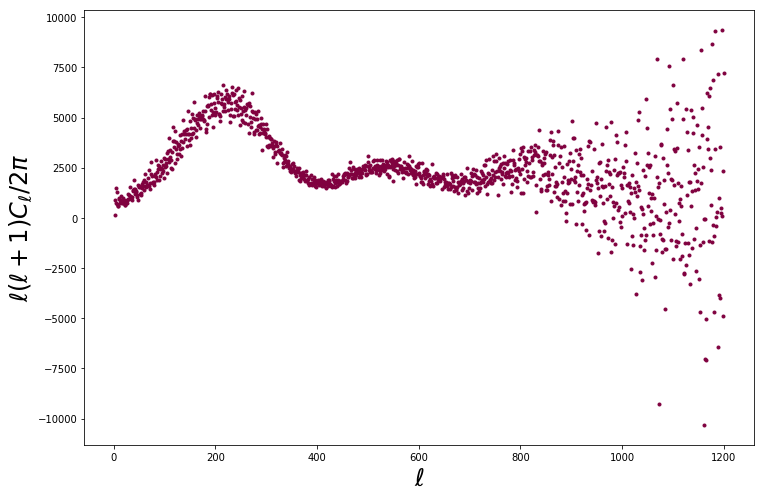

In [7]:
plt.plot(l,C_l,marker='.',ls='',c=c1)
plt.xlabel('$\ell$',fontsize=24)
plt.ylabel('$\ell (\ell + 1) C_\ell / 2\pi$',fontsize=24)
plt.show()

In [8]:
cosmology = np.array([0.02256,0.1142,2.40e-9,0.9710,0.0851,69.7])
npars = len(cosmology)

In [9]:
pars = camb.CAMBparams()
pars.set_cosmology(ombh2=cosmology[0],omch2=cosmology[1],tau=cosmology[4],H0=cosmology[5])
pars.InitPower.set_params(As=cosmology[2],ns=cosmology[3])
pars.set_for_lmax(int(l.max()))
results = camb.get_results(pars)
powers = results.get_cmb_power_spectra(pars, CMB_unit='muK')

In [10]:
C_l_gen = powers['total'][int(l.min()):int(l.max()+1),0]

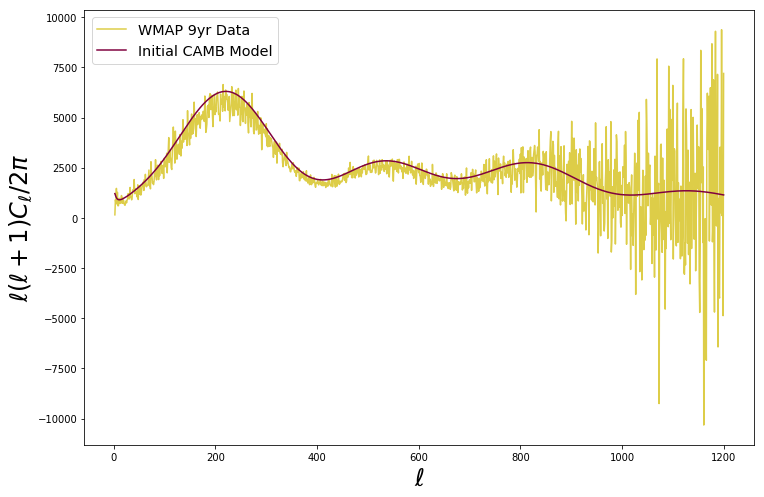

In [11]:
plt.plot(l,C_l,c=c2,alpha=0.75,label='WMAP 9yr Data')
plt.plot(l,C_l_gen,c=c1,label='Initial CAMB Model')
plt.xlabel('$\ell$',fontsize=24)
plt.ylabel('$\ell (\ell + 1) C_\ell / 2\pi$',fontsize=24)
plt.legend(fontsize='x-large')
plt.show()

# b)

In [12]:
def get_chisq(data,model,sigma):
    chisq = np.sum((data-model)**2/sigma**2)
    return chisq

In [13]:
def get_step(step_size=[1,1,1,1,1,1]):
    step_size = np.array(step_size)
    step = np.random.randn(len(step_size))*step_size
    return step

In [14]:
def get_spectrum(cosmology):
    pars = camb.CAMBparams()
    pars.set_cosmology(ombh2=cosmology[0],omch2=cosmology[1],tau=cosmology[4],H0=cosmology[5])
    pars.InitPower.set_params(As=cosmology[2],ns=cosmology[3])
    pars.set_for_lmax(int(l.max()))
    results = camb.get_results(pars)
    powers = results.get_cmb_power_spectra(pars, CMB_unit='muK')
    C_l_gen_new = powers['total'][int(l.min()):int(l.max()+1),0]
    return C_l_gen_new

In [145]:
def run_mcmc(data,err,init_cosmology,init_chisq,step_size,nstep,old_chain=None,
             save_fn=None,covariance=None):
    
    n_accepted = 0
    
    if old_chain is not None:
        chain = old_chain
        len_chain = len(old_chain)
        chain = np.append(chain,np.zeros((nstep,len(init_cosmology)+2)),axis=0)
        for i in range(len(init_cosmology)):
            init_cosmology[i] = chain[len_chain-1,i+2]
        model = get_spectrum(init_cosmology)
        init_chisq = get_chisq(data,model,err)
        print('Initial chisq: %.2f' %(init_chisq))
    else:
        chain = np.zeros((nstep,len(init_cosmology)+2))
        len_chain = 0
    
    for i in range(len_chain,len_chain+nstep):
        
        chain[i,0] = i+1
        print('On step %.0f' % (i+1))
        
        if covariance is None:
            step = get_step(step_size=step_size)
        else:
            step = simulate_corrnoise(covariance)
            step = step.T[0]
            
        new_cosmology = init_cosmology + step
        C_l_gen_new = get_spectrum(new_cosmology)
        new_chisq = get_chisq(data,C_l_gen_new,err)
        delchisq = new_chisq - init_chisq
        
        prob = np.exp(-0.5*delchisq)
        accept = np.random.rand() < prob
        #Need to give the prior that tau can't be negative
        accept = accept & (new_cosmology[4] > 0)
        
        if accept:
            print('Step accepted!')
            print('Delta chisq: %.2f' % (delchisq))
            print('Probability: %.2f \n' % (prob))
            
            n_accepted += 1
            init_cosmology = new_cosmology
            init_chisq = new_chisq
            
        chain[i,1] = init_chisq
        chain[i,2:len(init_cosmology)+2] = init_cosmology
        
        if save_fn is not None:
            np.save(save_fn,chain)
        
    print('Percentage of steps accepted: %.2f' % (n_accepted/nstep))
    return chain

I'll try and figure out a good stepsize for my parameters. My method is essentially starting with a 5% delta in the parameter value for a step size, and editing if I find the chain is rejecting/accepting too many steps.

In [16]:
steps = np.ones(npars)
chisq = get_chisq(C_l,C_l_gen,err)
names = ['$\Omega_b h^2$','$\Omega_c h^2$','$A_s$','$n_s$',r'$\tau$','$H_0$']

### Find trial step sizes for each parameter

In [17]:
def parabola(x,a,b,c):
    return a*x**2 + b*x + c

On step 1
On step 2
On step 3
On step 4
Step accepted!
Delta chisq: -0.57
Probability: 1.33 

On step 5
Step accepted!
Delta chisq: -4.20
Probability: 8.15 

On step 6
Step accepted!
Delta chisq: 3.00
Probability: 0.22 

On step 7
Step accepted!
Delta chisq: -2.30
Probability: 3.16 

On step 8
On step 9
Step accepted!
Delta chisq: -0.55
Probability: 1.31 

On step 10
Step accepted!
Delta chisq: 0.57
Probability: 0.75 

On step 11
On step 12
On step 13
On step 14
Step accepted!
Delta chisq: 0.41
Probability: 0.81 

On step 15
On step 16
Step accepted!
Delta chisq: 0.48
Probability: 0.78 

On step 17
On step 18
Step accepted!
Delta chisq: -1.07
Probability: 1.71 

On step 19
On step 20
On step 21
On step 22
Step accepted!
Delta chisq: 2.86
Probability: 0.24 

On step 23
Step accepted!
Delta chisq: -2.09
Probability: 2.84 

On step 24
On step 25
Step accepted!
Delta chisq: -0.55
Probability: 1.31 

On step 26
On step 27
Step accepted!
Delta chisq: -0.62
Probability: 1.37 

On step 28
On s

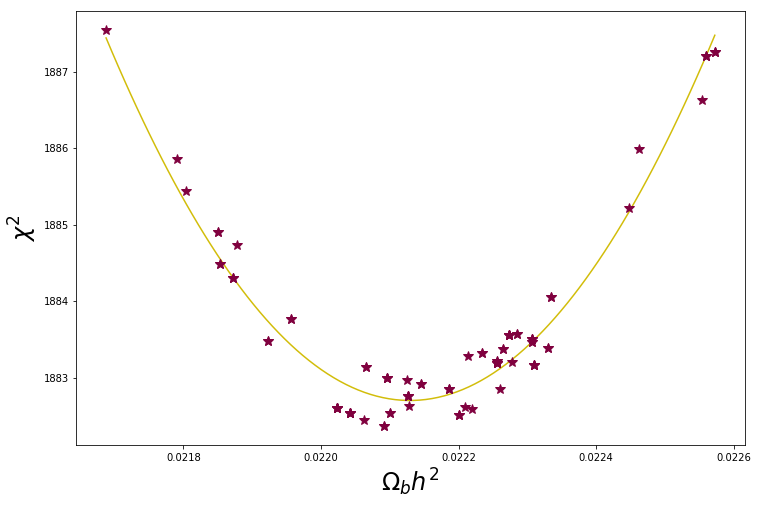

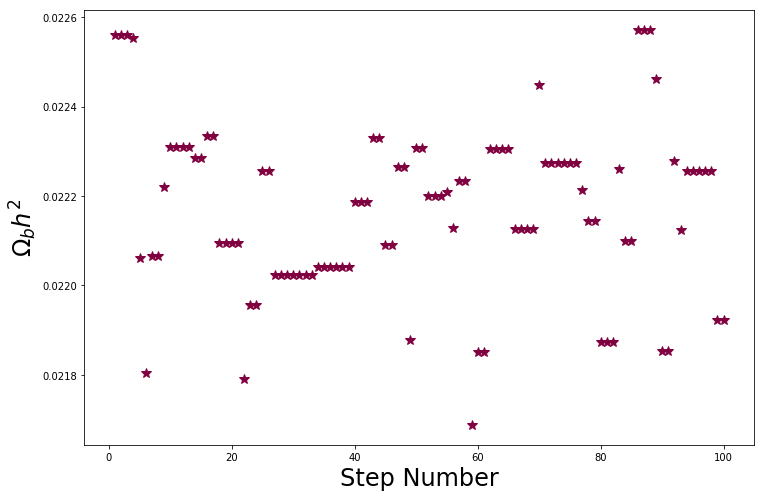

On step 1
On step 2
On step 3
Step accepted!
Delta chisq: -68.85
Probability: 890778020935473.38 

On step 4
On step 5
Step accepted!
Delta chisq: 0.21
Probability: 0.90 

On step 6
On step 7
Step accepted!
Delta chisq: -129.90
Probability: 16153496662039439731538788352.00 

On step 8
On step 9
Step accepted!
Delta chisq: -123.34
Probability: 606761878302935253241561088.00 

On step 10
Step accepted!
Delta chisq: -80.65
Probability: 326151073762737152.00 

On step 11
Step accepted!
Delta chisq: -41.07
Probability: 830461075.06 

On step 12
Step accepted!
Delta chisq: -10.10
Probability: 156.19 

On step 13
On step 14
On step 15
Step accepted!
Delta chisq: -39.18
Probability: 321294772.72 

On step 16
Step accepted!
Delta chisq: -33.02
Probability: 14793270.62 

On step 17
Step accepted!
Delta chisq: -2.88
Probability: 4.23 

On step 18
On step 19
Step accepted!
Delta chisq: -8.37
Probability: 65.82 

On step 20
On step 21
On step 22
On step 23
On step 24
On step 25
On step 26
On step 2

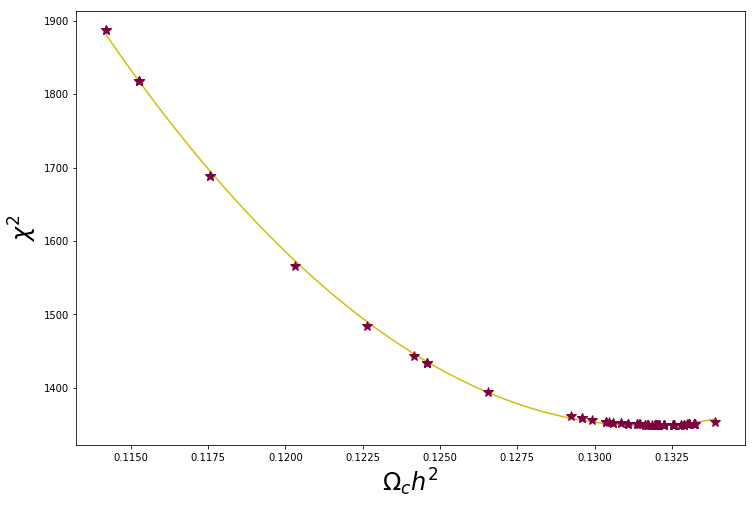

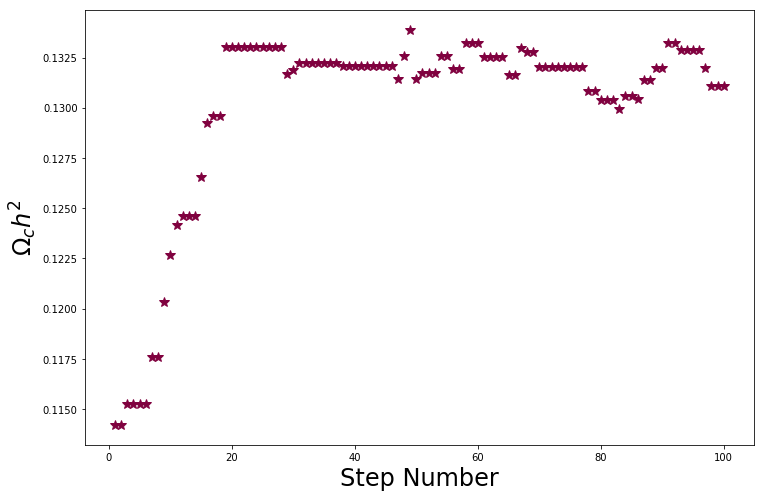

On step 1
Step accepted!
Delta chisq: -122.55
Probability: 409060948197295618009333760.00 

On step 2
On step 3
On step 4
On step 5
Step accepted!
Delta chisq: -294.45
Probability: 8710160112418059170160956398671470942709732009289575639214456832.00 

On step 6
Step accepted!
Delta chisq: -223.12
Probability: 2822364559434305221640241270777001787034217480192.00 

On step 7
Step accepted!
Delta chisq: -18.56
Probability: 10747.61 

On step 8
Step accepted!
Delta chisq: 0.13
Probability: 0.94 

On step 9
On step 10
Step accepted!
Delta chisq: 2.21
Probability: 0.33 

On step 11
On step 12
Step accepted!
Delta chisq: -1.18
Probability: 1.81 

On step 13
On step 14
On step 15
Step accepted!
Delta chisq: -1.07
Probability: 1.71 

On step 16
On step 17
On step 18
On step 19
On step 20
On step 21
On step 22
On step 23
On step 24
Step accepted!
Delta chisq: 1.02
Probability: 0.60 

On step 25
On step 26
On step 27
Step accepted!
Delta chisq: 2.04
Probability: 0.36 

On step 28
Step accepted!
De

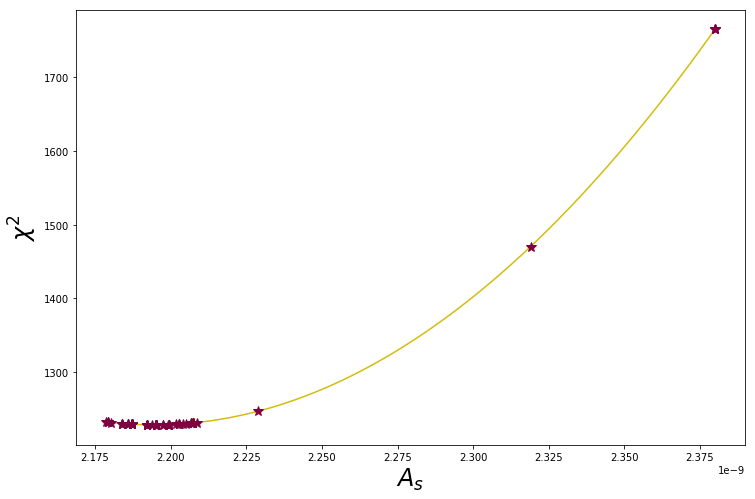

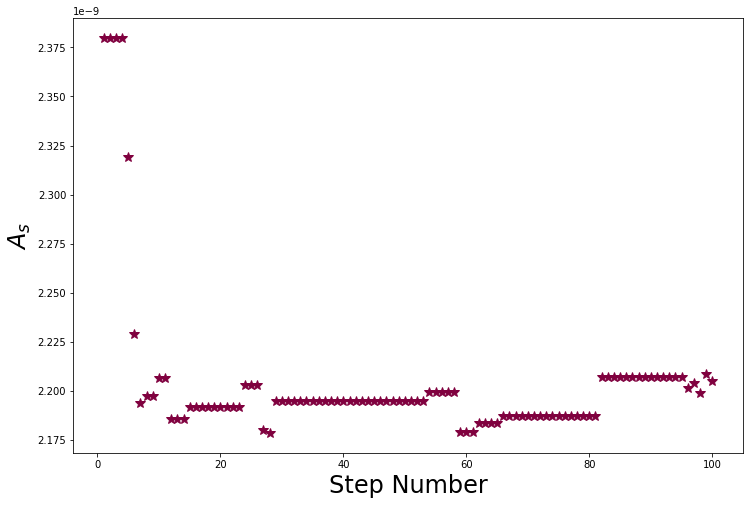

On step 1
Step accepted!
Delta chisq: -133.86
Probability: 116547384906761130376735752192.00 

On step 2
Step accepted!
Delta chisq: -116.39
Probability: 18758653469969666822635520.00 

On step 3
On step 4
On step 5
Step accepted!
Delta chisq: -7.37
Probability: 39.92 

On step 6
On step 7
On step 8
Step accepted!
Delta chisq: -42.09
Probability: 1381876475.76 

On step 9
On step 10
On step 11
On step 12
On step 13
On step 14
On step 15
Step accepted!
Delta chisq: -0.02
Probability: 1.01 

On step 16
On step 17
Step accepted!
Delta chisq: -0.74
Probability: 1.45 

On step 18
Step accepted!
Delta chisq: -0.15
Probability: 1.08 

On step 19
On step 20
On step 21
Step accepted!
Delta chisq: 0.48
Probability: 0.79 

On step 22
Step accepted!
Delta chisq: 0.72
Probability: 0.70 

On step 23
On step 24
On step 25
On step 26
Step accepted!
Delta chisq: -1.19
Probability: 1.81 

On step 27
On step 28
On step 29
On step 30
Step accepted!
Delta chisq: -0.02
Probability: 1.01 

On step 31
Step ac

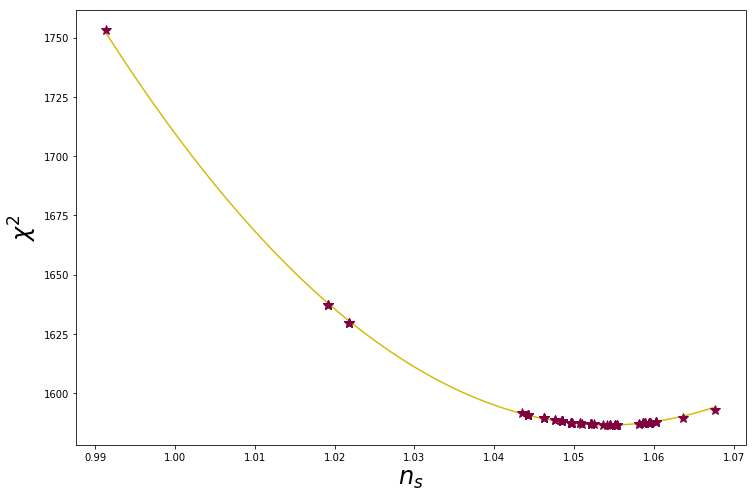

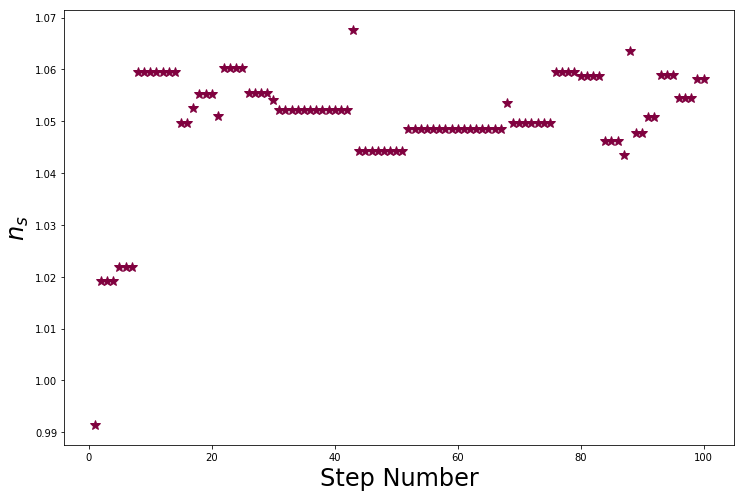

On step 1
On step 2
On step 3
Step accepted!
Delta chisq: -15.99
Probability: 2968.16 

On step 4
On step 5
On step 6
Step accepted!
Delta chisq: -33.52
Probability: 19026722.98 

On step 7
Step accepted!
Delta chisq: -56.61
Probability: 1965029663242.43 

On step 8
Step accepted!
Delta chisq: -49.30
Probability: 50718528545.59 

On step 9
Step accepted!
Delta chisq: -103.94
Probability: 37249061437412661526528.00 

On step 10
On step 11
On step 12
Step accepted!
Delta chisq: -15.09
Probability: 1892.22 

On step 13
On step 14
Step accepted!
Delta chisq: -44.38
Probability: 4336505245.78 

On step 15
On step 16
Step accepted!
Delta chisq: -69.73
Probability: 1388439392089260.25 

On step 17
On step 18
On step 19
Step accepted!
Delta chisq: -31.28
Probability: 6197322.97 

On step 20
On step 21
On step 22
Step accepted!
Delta chisq: -5.24
Probability: 13.71 

On step 23
On step 24
On step 25
On step 26
On step 27
Step accepted!
Delta chisq: 0.65
Probability: 0.72 

On step 28
On step 29

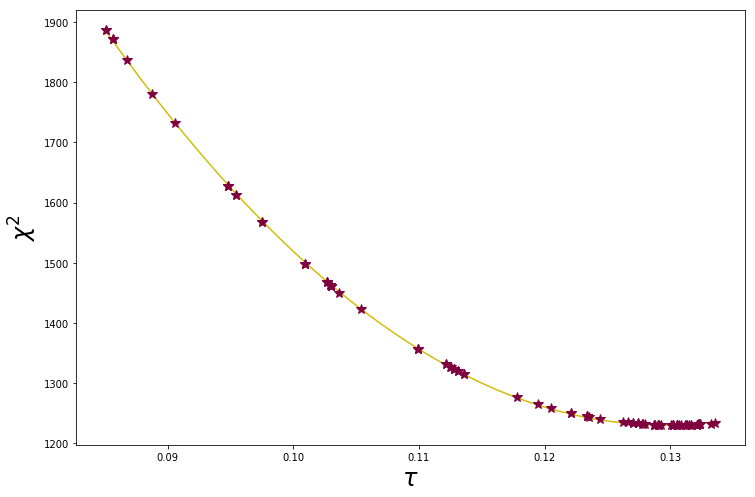

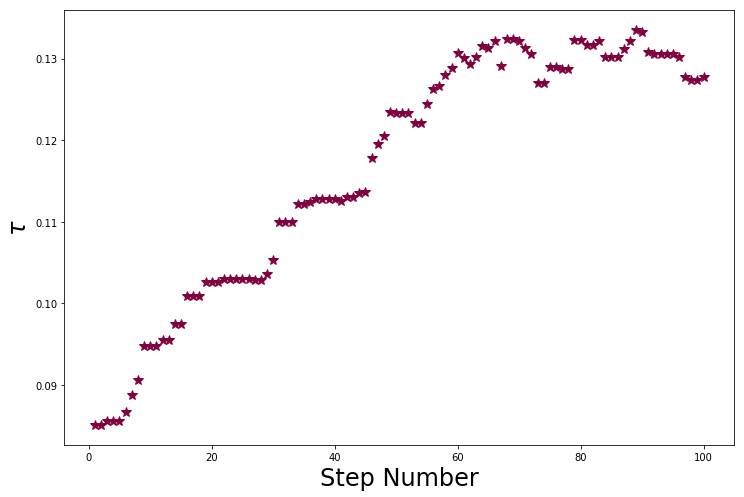

On step 1
Step accepted!
Delta chisq: -26.17
Probability: 481485.26 

On step 2
On step 3
Step accepted!
Delta chisq: -3.41
Probability: 5.50 

On step 4
Step accepted!
Delta chisq: -4.09
Probability: 7.73 

On step 5
Step accepted!
Delta chisq: 0.40
Probability: 0.82 

On step 6
Step accepted!
Delta chisq: 1.78
Probability: 0.41 

On step 7
Step accepted!
Delta chisq: 2.75
Probability: 0.25 

On step 8
Step accepted!
Delta chisq: -4.65
Probability: 10.23 

On step 9
On step 10
On step 11
On step 12
On step 13
Step accepted!
Delta chisq: 1.05
Probability: 0.59 

On step 14
Step accepted!
Delta chisq: -0.52
Probability: 1.30 

On step 15
On step 16
Step accepted!
Delta chisq: -0.02
Probability: 1.01 

On step 17
On step 18
On step 19
On step 20
On step 21
Step accepted!
Delta chisq: 0.22
Probability: 0.90 

On step 22
On step 23
Step accepted!
Delta chisq: 0.42
Probability: 0.81 

On step 24
Step accepted!
Delta chisq: -0.15
Probability: 1.08 

On step 25
Step accepted!
Delta chisq: 0.7

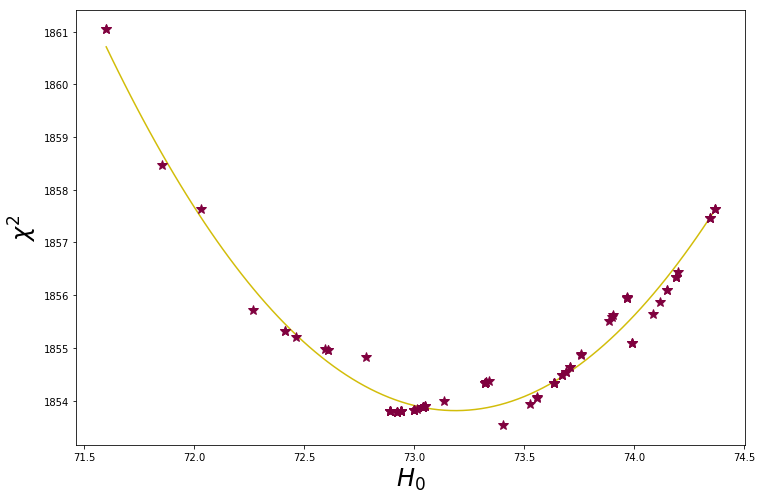

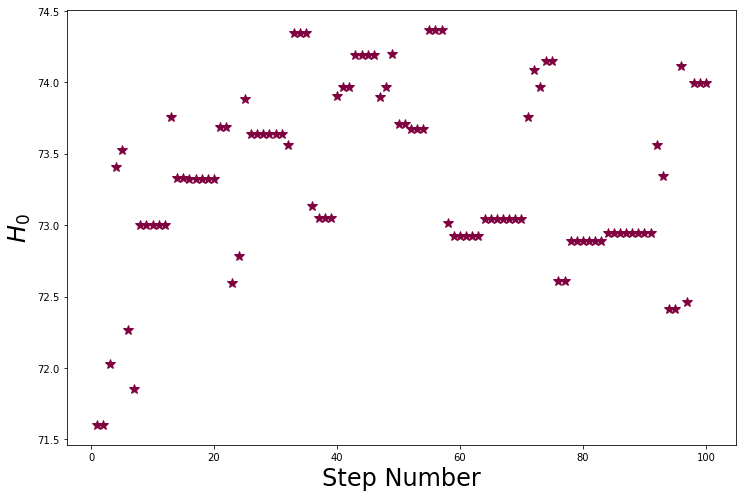

In [23]:
approx_steps = np.zeros(npars)
cosmology_guess = np.zeros(npars)

for i in range(npars):
    
    step_size = [0,0,0,0,0,0]
    step_size[i] = 0.025*cosmology[i]
    nstep = 100
    chain_param = run_mcmc(C_l,err,cosmology.copy(),chisq,step_size,nstep)
    param = chain_param[:,(i+2)]
    chisq_param = chain_param[:,1]
    step_num = chain_param[:,0]
    _,inds = np.unique(param,return_index=True)
    p = np.polyfit(param,chisq_param,2)
    x = np.linspace(param.min(),param.max(),100)
    
    plt.plot(x,parabola(x,*p),c=c2)
    plt.plot(param,chisq_param,marker='*',ls='',c=c1,markersize=10)
    plt.ylabel('$\chi^2$',fontsize=24)
    plt.xlabel(names[i],fontsize=24)
    plt.show()
    
    plt.plot(step_num,param,c=c1,ls='',marker='*',markersize=10)
    plt.xlabel('Step Number',fontsize=24)
    plt.ylabel(names[i],fontsize=24)
    plt.show()
    
    approx_steps[i] = 1/p[0]**0.5
    cosmology_guess[i] = (param[inds])[np.argmin(chisq_param[inds])]
    np.save(names[i],param)
    np.save('chisq_' + names[i],chisq_param)
    
np.save('cosmology_guess',cosmology_guess)
np.save('approx_steps',approx_steps)

In [43]:
C_l_guess = get_spectrum(cosmology_guess)
chisq_guess = get_chisq(C_l,C_l_gen,err)

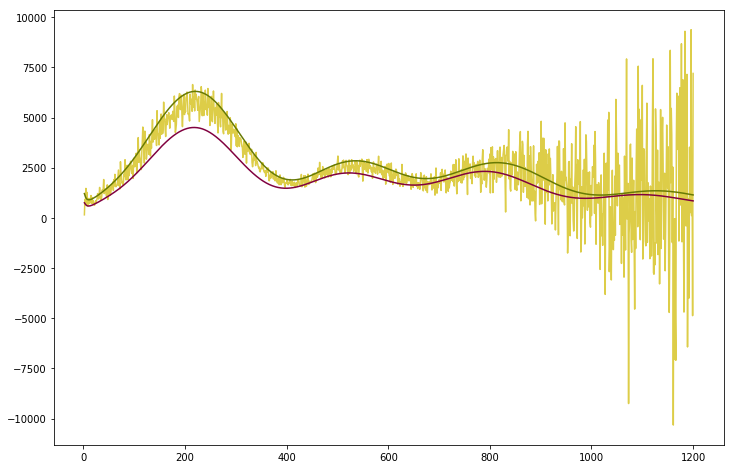

In [49]:
plt.plot(l,C_l,alpha=0.75,c=c2)
plt.plot(l,C_l_guess,c=c1)
plt.plot(l,C_l_gen,c=c3)
plt.show()

### Trial Chain Varying All Parameters!!

In [21]:
import time
import os

In [22]:
approx_steps = np.load('approx_steps.npy')

In [43]:
step_size = approx_steps
fn = 'chain_save.npy'
nstep = 1592

if os.path.exists(fn):
    chain_save = np.load(fn)
    up_to = int(chain_save[:,0].max())
    chain_save = chain_save[:up_to]
    t1 = time.time()
    chain_trial = run_mcmc(C_l,err,cosmology,chisq,step_size,nstep,old_chain=chain_save,save_fn=fn)
    t2 = time.time()
    print('Time to run: %.1f seconds' % (t2-t1))
else:
    t1 = time.time()
    chain_trial = run_mcmc(C_l,err,cosmology,chisq,step_size,nstep)
    t2 = time.time()
    print('Time to run: %.1f seconds' % (t2-t1))

Initial chisq: 1229.91
On step 4409
Step accepted!
Delta chisq: -0.75
Probability: 1.45 

On step 4410
On step 4411
On step 4412
On step 4413
Step accepted!
Delta chisq: 2.17
Probability: 0.34 

On step 4414
Step accepted!
Delta chisq: 0.63
Probability: 0.73 

On step 4415
Step accepted!
Delta chisq: 2.18
Probability: 0.34 

On step 4416
Step accepted!
Delta chisq: -0.85
Probability: 1.53 

On step 4417
On step 4418
On step 4419
Step accepted!
Delta chisq: -2.71
Probability: 3.88 

On step 4420
Step accepted!
Delta chisq: 1.56
Probability: 0.46 

On step 4421
On step 4422
Step accepted!
Delta chisq: -0.54
Probability: 1.31 

On step 4423
Step accepted!
Delta chisq: 2.60
Probability: 0.27 

On step 4424
On step 4425
On step 4426
Step accepted!
Delta chisq: 0.00
Probability: 1.00 

On step 4427
Step accepted!
Delta chisq: -1.67
Probability: 2.31 

On step 4428
On step 4429
On step 4430
On step 4431
On step 4432
On step 4433
On step 4434
Step accepted!
Delta chisq: -4.07
Probability: 7.65

Step accepted!
Delta chisq: 3.35
Probability: 0.19 

On step 4666
Step accepted!
Delta chisq: -3.20
Probability: 4.97 

On step 4667
On step 4668
On step 4669
On step 4670
On step 4671
On step 4672
On step 4673
On step 4674
On step 4675
On step 4676
On step 4677
On step 4678
On step 4679
On step 4680
On step 4681
On step 4682
On step 4683
On step 4684
Step accepted!
Delta chisq: 2.64
Probability: 0.27 

On step 4685
On step 4686
On step 4687
Step accepted!
Delta chisq: 0.65
Probability: 0.72 

On step 4688
Step accepted!
Delta chisq: -0.13
Probability: 1.07 

On step 4689
On step 4690
Step accepted!
Delta chisq: -1.89
Probability: 2.58 

On step 4691
Step accepted!
Delta chisq: -0.90
Probability: 1.57 

On step 4692
Step accepted!
Delta chisq: 0.31
Probability: 0.86 

On step 4693
On step 4694
On step 4695
On step 4696
On step 4697
On step 4698
Step accepted!
Delta chisq: 2.27
Probability: 0.32 

On step 4699
On step 4700
On step 4701
Step accepted!
Delta chisq: -0.73
Probability: 1.44

On step 4950
On step 4951
Step accepted!
Delta chisq: 4.09
Probability: 0.13 

On step 4952
On step 4953
On step 4954
Step accepted!
Delta chisq: -2.07
Probability: 2.82 

On step 4955
Step accepted!
Delta chisq: -0.52
Probability: 1.30 

On step 4956
On step 4957
On step 4958
On step 4959
On step 4960
On step 4961
On step 4962
Step accepted!
Delta chisq: -1.34
Probability: 1.95 

On step 4963
On step 4964
On step 4965
On step 4966
On step 4967
On step 4968
Step accepted!
Delta chisq: 0.91
Probability: 0.63 

On step 4969
Step accepted!
Delta chisq: -0.26
Probability: 1.14 

On step 4970
Step accepted!
Delta chisq: -1.15
Probability: 1.77 

On step 4971
On step 4972
Step accepted!
Delta chisq: 0.30
Probability: 0.86 

On step 4973
On step 4974
On step 4975
On step 4976
On step 4977
On step 4978
On step 4979
Step accepted!
Delta chisq: -0.21
Probability: 1.11 

On step 4980
On step 4981
On step 4982
On step 4983
On step 4984
Step accepted!
Delta chisq: 2.31
Probability: 0.31 

On step 4

Step accepted!
Delta chisq: 4.43
Probability: 0.11 

On step 5198
On step 5199
On step 5200
Step accepted!
Delta chisq: -3.16
Probability: 4.85 

On step 5201
Step accepted!
Delta chisq: -2.77
Probability: 4.00 

On step 5202
Step accepted!
Delta chisq: 3.61
Probability: 0.16 

On step 5203
On step 5204
Step accepted!
Delta chisq: -0.98
Probability: 1.63 

On step 5205
On step 5206
On step 5207
Step accepted!
Delta chisq: -1.24
Probability: 1.86 

On step 5208
On step 5209
Step accepted!
Delta chisq: 3.10
Probability: 0.21 

On step 5210
On step 5211
On step 5212
On step 5213
On step 5214
On step 5215
Step accepted!
Delta chisq: -0.05
Probability: 1.03 

On step 5216
Step accepted!
Delta chisq: 0.84
Probability: 0.66 

On step 5217
On step 5218
Step accepted!
Delta chisq: 0.34
Probability: 0.84 

On step 5219
Step accepted!
Delta chisq: 3.05
Probability: 0.22 

On step 5220
Step accepted!
Delta chisq: 1.69
Probability: 0.43 

On step 5221
On step 5222
On step 5223
On step 5224
On step 

On step 5474
On step 5475
On step 5476
On step 5477
On step 5478
On step 5479
Step accepted!
Delta chisq: -0.38
Probability: 1.21 

On step 5480
On step 5481
Step accepted!
Delta chisq: 0.74
Probability: 0.69 

On step 5482
On step 5483
On step 5484
On step 5485
Step accepted!
Delta chisq: -0.77
Probability: 1.47 

On step 5486
On step 5487
Step accepted!
Delta chisq: 1.39
Probability: 0.50 

On step 5488
On step 5489
Step accepted!
Delta chisq: -1.22
Probability: 1.84 

On step 5490
On step 5491
On step 5492
On step 5493
On step 5494
Step accepted!
Delta chisq: 0.64
Probability: 0.73 

On step 5495
Step accepted!
Delta chisq: -2.40
Probability: 3.32 

On step 5496
On step 5497
Step accepted!
Delta chisq: -0.28
Probability: 1.15 

On step 5498
Step accepted!
Delta chisq: 4.09
Probability: 0.13 

On step 5499
Step accepted!
Delta chisq: 0.42
Probability: 0.81 

On step 5500
On step 5501
On step 5502
On step 5503
Step accepted!
Delta chisq: -0.79
Probability: 1.48 

On step 5504
Step acc

On step 5758
Step accepted!
Delta chisq: 0.42
Probability: 0.81 

On step 5759
On step 5760
On step 5761
On step 5762
On step 5763
Step accepted!
Delta chisq: -1.21
Probability: 1.83 

On step 5764
On step 5765
Step accepted!
Delta chisq: -1.45
Probability: 2.07 

On step 5766
On step 5767
On step 5768
On step 5769
On step 5770
Step accepted!
Delta chisq: 0.30
Probability: 0.86 

On step 5771
On step 5772
On step 5773
Step accepted!
Delta chisq: 2.95
Probability: 0.23 

On step 5774
On step 5775
On step 5776
Step accepted!
Delta chisq: 1.55
Probability: 0.46 

On step 5777
Step accepted!
Delta chisq: -3.36
Probability: 5.38 

On step 5778
Step accepted!
Delta chisq: 1.20
Probability: 0.55 

On step 5779
On step 5780
On step 5781
On step 5782
On step 5783
On step 5784
On step 5785
Step accepted!
Delta chisq: 3.74
Probability: 0.15 

On step 5786
On step 5787
On step 5788
Step accepted!
Delta chisq: -0.05
Probability: 1.03 

On step 5789
On step 5790
Step accepted!
Delta chisq: -2.16
Pro

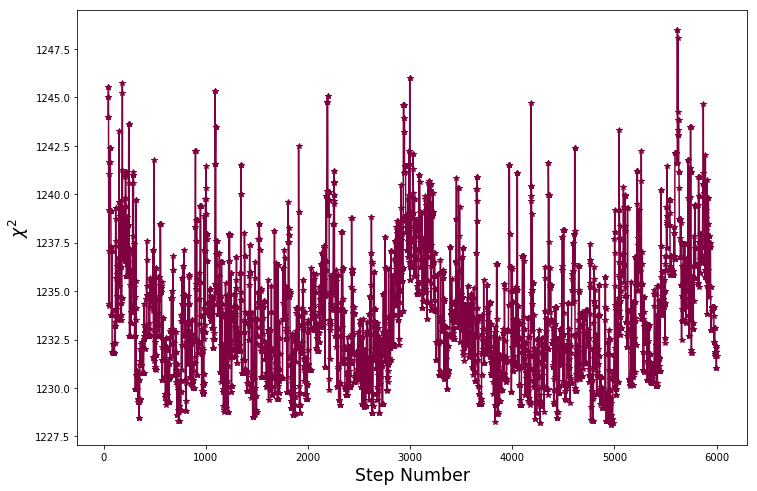

In [153]:
fn = 'chain_save.npy'
chain_trial = np.load(fn)
up_to = int(chain_trial[:,0].max())
chain_trial = chain_trial[:up_to]
start = 40
plt.plot(chain_trial[start:,0],chain_trial[start:,1],marker='*',c=c1)
plt.ylabel('$\chi^2$',fontsize='xx-large')
plt.xlabel('Step Number',fontsize='xx-large')
plt.show()

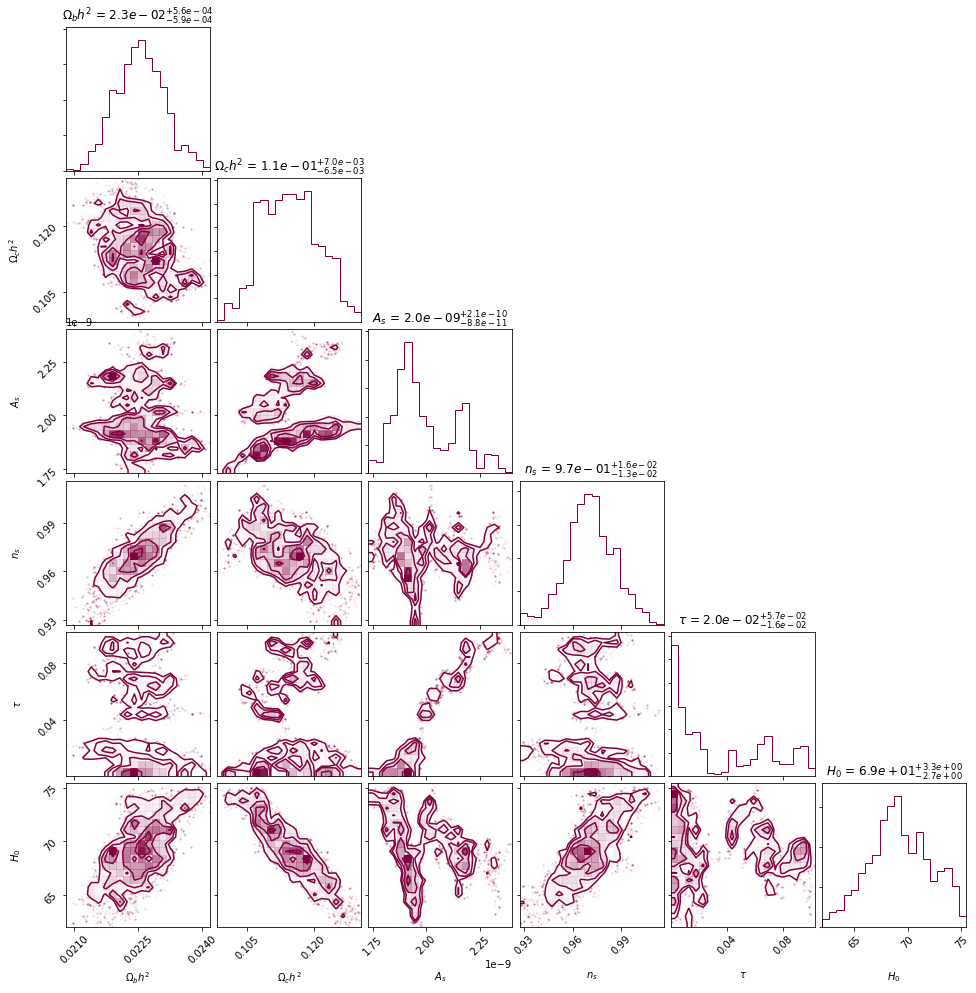

In [104]:
corner.corner(chain_trial[:,2:],color=c1,max_n_ticks=3,labels=names,show_titles=True,
             title_fmt='.1e')
plt.show()

In [131]:
cov = np.cov(chain_trial[:,2:].T)

In [110]:
def simulate_corrnoise(mat,nset=1):
    e,v=np.linalg.eigh(mat)
    e[e<0]=0 #make sure we don't have any negative eigenvalues due to roundoff
    n=len(e)
    #make gaussian random variables
    g=np.random.randn(n,nset)
    #now scale them by the square root of the eigenvalues
    rte=np.sqrt(e)
    for i in range(nset):
        g[:,i]=g[:,i]*rte
    #and rotate back into the original space
    dat=np.dot(v,g)
    return dat

In [135]:
test = simulate_corrnoise(cov,nset=3000)

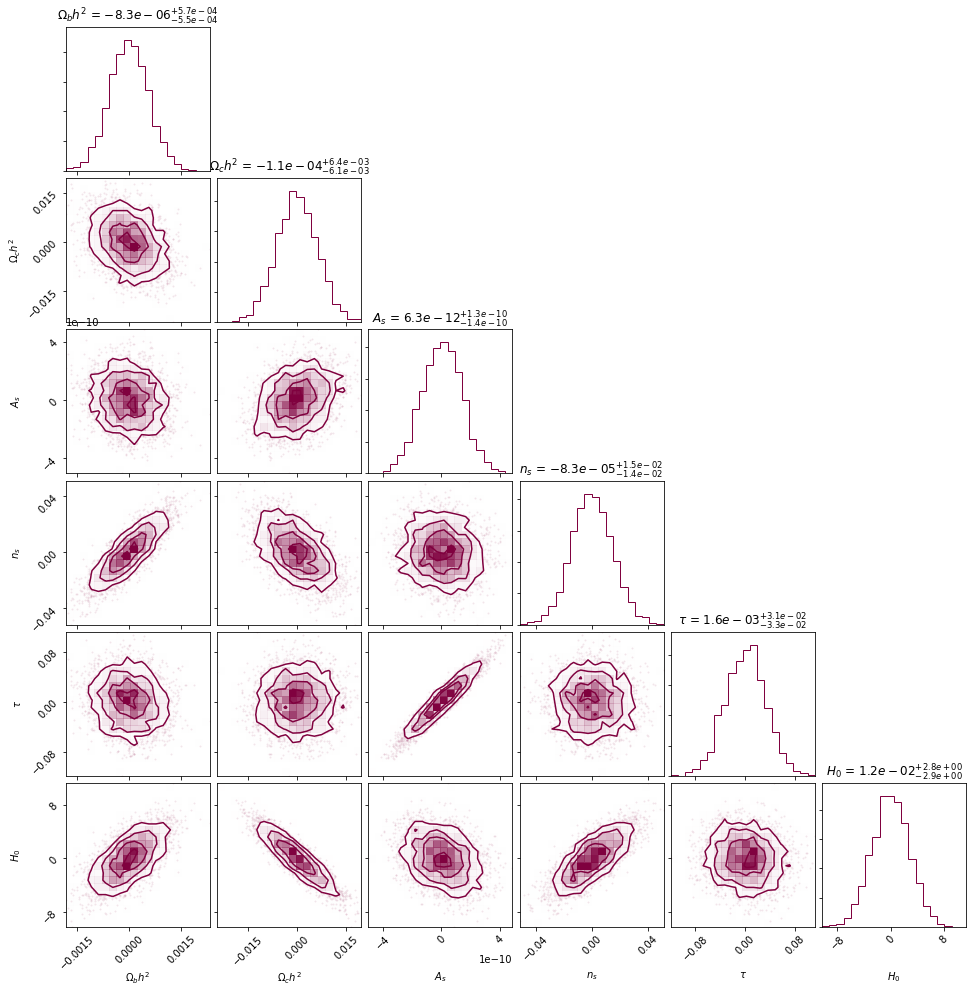

In [139]:
corner.corner(test.T,color=c1,max_n_ticks=3,labels=names,show_titles=True,
             title_fmt='.1e')
plt.show()

### Covariant Step Chain

In [151]:
fn = 'chain_cov_save.npy'
nstep = 9900

if os.path.exists(fn):
    chain_save = np.load(fn)
    up_to = int(chain_save[:,0].max())
    chain_save = chain_save[:up_to]
    t1 = time.time()
    chain_trial = run_mcmc(C_l,err,cosmology,chisq,step_size,nstep,
                           old_chain=chain_save,save_fn=fn)
    t2 = time.time()
    print('Time to run: %.1f seconds' % (t2-t1))
else:
    t1 = time.time()
    chain_trial = run_mcmc(C_l,err,cosmology,chisq,step_size,nstep,
                           save_fn=fn,covariance=cov)
    t2 = time.time()
    print('Time to run: %.1f seconds' % (t2-t1))

Initial chisq: 1231.68
On step 101
On step 102
On step 103
On step 104
Step accepted!
Delta chisq: 2.60
Probability: 0.27 

On step 105
On step 106
Step accepted!
Delta chisq: -1.84
Probability: 2.51 

On step 107
Step accepted!
Delta chisq: -0.11
Probability: 1.06 

On step 108
Step accepted!
Delta chisq: 3.16
Probability: 0.21 

On step 109
Step accepted!
Delta chisq: -2.93
Probability: 4.33 

On step 110
On step 111
On step 112
Step accepted!
Delta chisq: 2.42
Probability: 0.30 

On step 113
On step 114
On step 115
On step 116
Step accepted!
Delta chisq: 1.71
Probability: 0.42 

On step 117
On step 118
On step 119
Step accepted!
Delta chisq: -0.51
Probability: 1.29 

On step 120
Step accepted!
Delta chisq: -3.54
Probability: 5.86 

On step 121
On step 122
Step accepted!
Delta chisq: -0.81
Probability: 1.50 

On step 123
On step 124
Step accepted!
Delta chisq: 4.42
Probability: 0.11 

On step 125
Step accepted!
Delta chisq: -3.26
Probability: 5.09 

On step 126
Step accepted!
Delta c

On step 386
On step 387
On step 388
Step accepted!
Delta chisq: -4.16
Probability: 8.01 

On step 389
On step 390
On step 391
On step 392
On step 393
Step accepted!
Delta chisq: 2.23
Probability: 0.33 

On step 394
Step accepted!
Delta chisq: 0.04
Probability: 0.98 

On step 395
On step 396
Step accepted!
Delta chisq: 0.15
Probability: 0.93 

On step 397
On step 398
Step accepted!
Delta chisq: 0.09
Probability: 0.95 

On step 399
Step accepted!
Delta chisq: 1.27
Probability: 0.53 

On step 400
Step accepted!
Delta chisq: 0.72
Probability: 0.70 

On step 401
Step accepted!
Delta chisq: -2.74
Probability: 3.93 

On step 402
On step 403
Step accepted!
Delta chisq: 2.33
Probability: 0.31 

On step 404
On step 405
On step 406
On step 407
Step accepted!
Delta chisq: 2.45
Probability: 0.29 

On step 408
On step 409
Step accepted!
Delta chisq: -0.22
Probability: 1.12 

On step 410
Step accepted!
Delta chisq: -0.87
Probability: 1.54 

On step 411
On step 412
Step accepted!
Delta chisq: -1.28
Pr

On step 664
On step 665
On step 666
Step accepted!
Delta chisq: -0.26
Probability: 1.14 

On step 667
Step accepted!
Delta chisq: -0.10
Probability: 1.05 

On step 668
On step 669
Step accepted!
Delta chisq: -1.47
Probability: 2.09 

On step 670
On step 671
On step 672
On step 673
On step 674
On step 675
On step 676
On step 677
Step accepted!
Delta chisq: 4.36
Probability: 0.11 

On step 678
Step accepted!
Delta chisq: 7.18
Probability: 0.03 

On step 679
Step accepted!
Delta chisq: -4.85
Probability: 11.28 

On step 680
On step 681
Step accepted!
Delta chisq: 2.41
Probability: 0.30 

On step 682
Step accepted!
Delta chisq: -2.21
Probability: 3.02 

On step 683
On step 684
Step accepted!
Delta chisq: 0.44
Probability: 0.80 

On step 685
On step 686
On step 687
Step accepted!
Delta chisq: 4.41
Probability: 0.11 

On step 688
On step 689
On step 690
Step accepted!
Delta chisq: -4.78
Probability: 10.93 

On step 691
On step 692
On step 693
Step accepted!
Delta chisq: 2.21
Probability: 0.3

On step 972
Step accepted!
Delta chisq: -1.16
Probability: 1.79 

On step 973
On step 974
On step 975
On step 976
Step accepted!
Delta chisq: 1.35
Probability: 0.51 

On step 977
On step 978
On step 979
On step 980
Step accepted!
Delta chisq: 0.61
Probability: 0.74 

On step 981
On step 982
Step accepted!
Delta chisq: -0.20
Probability: 1.10 

On step 983
On step 984
On step 985
On step 986
Step accepted!
Delta chisq: -0.52
Probability: 1.29 

On step 987
On step 988
On step 989
On step 990
Step accepted!
Delta chisq: -0.85
Probability: 1.53 

On step 991
On step 992
On step 993
Step accepted!
Delta chisq: -1.45
Probability: 2.07 

On step 994
On step 995
Step accepted!
Delta chisq: 2.42
Probability: 0.30 

On step 996
On step 997
On step 998
Step accepted!
Delta chisq: 0.39
Probability: 0.82 

On step 999
Step accepted!
Delta chisq: -0.45
Probability: 1.25 

On step 1000
Step accepted!
Delta chisq: 0.99
Probability: 0.61 

On step 1001
Step accepted!
Delta chisq: -4.18
Probability: 8.

Step accepted!
Delta chisq: 0.99
Probability: 0.61 

On step 1250
On step 1251
On step 1252
On step 1253
On step 1254
On step 1255
On step 1256
On step 1257
On step 1258
Step accepted!
Delta chisq: -0.69
Probability: 1.41 

On step 1259
Step accepted!
Delta chisq: -2.12
Probability: 2.88 

On step 1260
Step accepted!
Delta chisq: 3.93
Probability: 0.14 

On step 1261
On step 1262
On step 1263
Step accepted!
Delta chisq: -4.59
Probability: 9.93 

On step 1264
On step 1265
Step accepted!
Delta chisq: 3.45
Probability: 0.18 

On step 1266
On step 1267
Step accepted!
Delta chisq: -0.03
Probability: 1.01 

On step 1268
On step 1269
On step 1270
On step 1271
On step 1272
On step 1273
On step 1274
Step accepted!
Delta chisq: -5.80
Probability: 18.21 

On step 1275
On step 1276
Step accepted!
Delta chisq: -1.36
Probability: 1.97 

On step 1277
On step 1278
On step 1279
On step 1280
On step 1281
Step accepted!
Delta chisq: -1.28
Probability: 1.90 

On step 1282
On step 1283
On step 1284
On step

Step accepted!
Delta chisq: 0.14
Probability: 0.93 

On step 1539
Step accepted!
Delta chisq: -4.77
Probability: 10.87 

On step 1540
On step 1541
On step 1542
On step 1543
Step accepted!
Delta chisq: 0.17
Probability: 0.92 

On step 1544
On step 1545
On step 1546
Step accepted!
Delta chisq: -7.06
Probability: 34.20 

On step 1547
On step 1548
Step accepted!
Delta chisq: 3.25
Probability: 0.20 

On step 1549
Step accepted!
Delta chisq: 0.65
Probability: 0.72 

On step 1550
Step accepted!
Delta chisq: 1.98
Probability: 0.37 

On step 1551
On step 1552
On step 1553
On step 1554
Step accepted!
Delta chisq: -0.61
Probability: 1.36 

On step 1555
Step accepted!
Delta chisq: -3.22
Probability: 5.00 

On step 1556
Step accepted!
Delta chisq: 0.28
Probability: 0.87 

On step 1557
On step 1558
On step 1559
On step 1560
On step 1561
Step accepted!
Delta chisq: -1.16
Probability: 1.78 

On step 1562
Step accepted!
Delta chisq: -2.78
Probability: 4.01 

On step 1563
Step accepted!
Delta chisq: -0.

Step accepted!
Delta chisq: -0.44
Probability: 1.25 

On step 1798
Step accepted!
Delta chisq: -4.21
Probability: 8.19 

On step 1799
On step 1800
On step 1801
On step 1802
Step accepted!
Delta chisq: 4.17
Probability: 0.12 

On step 1803
On step 1804
On step 1805
On step 1806
On step 1807
On step 1808
On step 1809
On step 1810
On step 1811
On step 1812
On step 1813
On step 1814
On step 1815
On step 1816
On step 1817
On step 1818
On step 1819
Step accepted!
Delta chisq: 0.57
Probability: 0.75 

On step 1820
On step 1821
On step 1822
Step accepted!
Delta chisq: -0.14
Probability: 1.07 

On step 1823
On step 1824
Step accepted!
Delta chisq: -1.68
Probability: 2.31 

On step 1825
Step accepted!
Delta chisq: -2.92
Probability: 4.30 

On step 1826
Step accepted!
Delta chisq: 2.26
Probability: 0.32 

On step 1827
Step accepted!
Delta chisq: -0.65
Probability: 1.39 

On step 1828
Step accepted!
Delta chisq: -1.59
Probability: 2.21 

On step 1829
On step 1830
On step 1831
On step 1832
On step 

On step 2083
On step 2084
Step accepted!
Delta chisq: 0.07
Probability: 0.97 

On step 2085
On step 2086
Step accepted!
Delta chisq: 1.52
Probability: 0.47 

On step 2087
On step 2088
On step 2089
Step accepted!
Delta chisq: 1.31
Probability: 0.52 

On step 2090
On step 2091
Step accepted!
Delta chisq: 1.05
Probability: 0.59 

On step 2092
On step 2093
On step 2094
On step 2095
On step 2096
On step 2097
Step accepted!
Delta chisq: 0.05
Probability: 0.98 

On step 2098
On step 2099
Step accepted!
Delta chisq: -0.45
Probability: 1.25 

On step 2100
On step 2101
Step accepted!
Delta chisq: -1.45
Probability: 2.07 

On step 2102
On step 2103
On step 2104
On step 2105
Step accepted!
Delta chisq: 1.91
Probability: 0.38 

On step 2106
Step accepted!
Delta chisq: -0.44
Probability: 1.25 

On step 2107
On step 2108
On step 2109
On step 2110
On step 2111
On step 2112
On step 2113
On step 2114
Step accepted!
Delta chisq: -3.10
Probability: 4.71 

On step 2115
On step 2116
On step 2117
On step 211

Step accepted!
Delta chisq: -0.52
Probability: 1.30 

On step 2357
On step 2358
Step accepted!
Delta chisq: 1.65
Probability: 0.44 

On step 2359
On step 2360
On step 2361
Step accepted!
Delta chisq: 2.68
Probability: 0.26 

On step 2362
On step 2363
On step 2364
On step 2365
On step 2366
On step 2367
On step 2368
Step accepted!
Delta chisq: -3.49
Probability: 5.71 

On step 2369
On step 2370
On step 2371
On step 2372
Step accepted!
Delta chisq: 2.83
Probability: 0.24 

On step 2373
On step 2374
Step accepted!
Delta chisq: 0.63
Probability: 0.73 

On step 2375
On step 2376
Step accepted!
Delta chisq: 0.60
Probability: 0.74 

On step 2377
On step 2378
Step accepted!
Delta chisq: -0.58
Probability: 1.33 

On step 2379
Step accepted!
Delta chisq: -4.95
Probability: 11.89 

On step 2380
On step 2381
On step 2382
Step accepted!
Delta chisq: -1.49
Probability: 2.10 

On step 2383
Step accepted!
Delta chisq: 0.33
Probability: 0.85 

On step 2384
On step 2385
On step 2386
On step 2387
On step 

Step accepted!
Delta chisq: -0.96
Probability: 1.61 

On step 2619
On step 2620
Step accepted!
Delta chisq: 0.50
Probability: 0.78 

On step 2621
Step accepted!
Delta chisq: -4.45
Probability: 9.26 

On step 2622
On step 2623
On step 2624
On step 2625
Step accepted!
Delta chisq: -0.59
Probability: 1.34 

On step 2626
On step 2627
On step 2628
Step accepted!
Delta chisq: 1.36
Probability: 0.51 

On step 2629
On step 2630
On step 2631
Step accepted!
Delta chisq: 1.86
Probability: 0.39 

On step 2632
On step 2633
On step 2634
Step accepted!
Delta chisq: 1.94
Probability: 0.38 

On step 2635
On step 2636
On step 2637
On step 2638
On step 2639
Step accepted!
Delta chisq: -3.39
Probability: 5.45 

On step 2640
On step 2641
Step accepted!
Delta chisq: -1.15
Probability: 1.78 

On step 2642
On step 2643
On step 2644
Step accepted!
Delta chisq: 1.69
Probability: 0.43 

On step 2645
On step 2646
Step accepted!
Delta chisq: 0.43
Probability: 0.81 

On step 2647
On step 2648
On step 2649
Step acce

On step 2895
On step 2896
On step 2897
On step 2898
On step 2899
On step 2900
On step 2901
Step accepted!
Delta chisq: 0.39
Probability: 0.82 

On step 2902
On step 2903
Step accepted!
Delta chisq: 2.12
Probability: 0.35 

On step 2904
On step 2905
On step 2906
Step accepted!
Delta chisq: -1.57
Probability: 2.19 

On step 2907
On step 2908
On step 2909
On step 2910
Step accepted!
Delta chisq: 2.69
Probability: 0.26 

On step 2911
On step 2912
On step 2913
Step accepted!
Delta chisq: 0.07
Probability: 0.96 

On step 2914
Step accepted!
Delta chisq: -0.81
Probability: 1.50 

On step 2915
Step accepted!
Delta chisq: -0.90
Probability: 1.57 

On step 2916
On step 2917
Step accepted!
Delta chisq: 0.49
Probability: 0.78 

On step 2918
On step 2919
On step 2920
On step 2921
On step 2922
On step 2923
On step 2924
On step 2925
Step accepted!
Delta chisq: 0.15
Probability: 0.93 

On step 2926
Step accepted!
Delta chisq: 0.43
Probability: 0.81 

On step 2927
Step accepted!
Delta chisq: -1.51
Prob

On step 3167
On step 3168
On step 3169
On step 3170
On step 3171
Step accepted!
Delta chisq: -0.39
Probability: 1.22 

On step 3172
On step 3173
On step 3174
On step 3175
Step accepted!
Delta chisq: 1.25
Probability: 0.54 

On step 3176
On step 3177
On step 3178
Step accepted!
Delta chisq: 0.88
Probability: 0.65 

On step 3179
On step 3180
On step 3181
On step 3182
Step accepted!
Delta chisq: 0.31
Probability: 0.86 

On step 3183
On step 3184
On step 3185
Step accepted!
Delta chisq: 0.63
Probability: 0.73 

On step 3186
On step 3187
On step 3188
On step 3189
Step accepted!
Delta chisq: -0.60
Probability: 1.35 

On step 3190
On step 3191
Step accepted!
Delta chisq: 2.30
Probability: 0.32 

On step 3192
On step 3193
On step 3194
On step 3195
On step 3196
On step 3197
On step 3198
Step accepted!
Delta chisq: -1.14
Probability: 1.77 

On step 3199
On step 3200
Step accepted!
Delta chisq: 2.08
Probability: 0.35 

On step 3201
Step accepted!
Delta chisq: 2.73
Probability: 0.26 

On step 3202

On step 3427
Step accepted!
Delta chisq: -2.14
Probability: 2.91 

On step 3428
Step accepted!
Delta chisq: 0.24
Probability: 0.89 

On step 3429
Step accepted!
Delta chisq: -0.20
Probability: 1.11 

On step 3430
On step 3431
On step 3432
Step accepted!
Delta chisq: -2.06
Probability: 2.80 

On step 3433
On step 3434
On step 3435
On step 3436
On step 3437
Step accepted!
Delta chisq: 1.16
Probability: 0.56 

On step 3438
On step 3439
On step 3440
On step 3441
On step 3442
Step accepted!
Delta chisq: -0.16
Probability: 1.08 

On step 3443
On step 3444
Step accepted!
Delta chisq: 0.34
Probability: 0.84 

On step 3445
Step accepted!
Delta chisq: 4.36
Probability: 0.11 

On step 3446
On step 3447
Step accepted!
Delta chisq: 1.72
Probability: 0.42 

On step 3448
Step accepted!
Delta chisq: -1.93
Probability: 2.62 

On step 3449
On step 3450
Step accepted!
Delta chisq: 1.82
Probability: 0.40 

On step 3451
On step 3452
Step accepted!
Delta chisq: -2.37
Probability: 3.27 

On step 3453
On step

On step 3687
Step accepted!
Delta chisq: -0.63
Probability: 1.37 

On step 3688
On step 3689
On step 3690
Step accepted!
Delta chisq: 0.69
Probability: 0.71 

On step 3691
Step accepted!
Delta chisq: -0.38
Probability: 1.21 

On step 3692
Step accepted!
Delta chisq: 2.30
Probability: 0.32 

On step 3693
On step 3694
Step accepted!
Delta chisq: -0.00
Probability: 1.00 

On step 3695
On step 3696
Step accepted!
Delta chisq: 1.10
Probability: 0.58 

On step 3697
Step accepted!
Delta chisq: -0.53
Probability: 1.30 

On step 3698
Step accepted!
Delta chisq: -0.67
Probability: 1.39 

On step 3699
On step 3700
On step 3701
Step accepted!
Delta chisq: -0.31
Probability: 1.17 

On step 3702
On step 3703
Step accepted!
Delta chisq: 1.29
Probability: 0.53 

On step 3704
Step accepted!
Delta chisq: -0.18
Probability: 1.09 

On step 3705
On step 3706
On step 3707
On step 3708
Step accepted!
Delta chisq: -1.01
Probability: 1.66 

On step 3709
Step accepted!
Delta chisq: 2.31
Probability: 0.32 

On s

Step accepted!
Delta chisq: -0.55
Probability: 1.32 

On step 3955
On step 3956
On step 3957
Step accepted!
Delta chisq: -0.37
Probability: 1.20 

On step 3958
On step 3959
Step accepted!
Delta chisq: 4.01
Probability: 0.13 

On step 3960
Step accepted!
Delta chisq: -2.73
Probability: 3.92 

On step 3961
On step 3962
On step 3963
On step 3964
On step 3965
On step 3966
On step 3967
Step accepted!
Delta chisq: -0.61
Probability: 1.36 

On step 3968
On step 3969
On step 3970
Step accepted!
Delta chisq: 2.96
Probability: 0.23 

On step 3971
Step accepted!
Delta chisq: 1.48
Probability: 0.48 

On step 3972
Step accepted!
Delta chisq: -2.87
Probability: 4.20 

On step 3973
Step accepted!
Delta chisq: -3.06
Probability: 4.61 

On step 3974
On step 3975
On step 3976
Step accepted!
Delta chisq: 0.55
Probability: 0.76 

On step 3977
On step 3978
Step accepted!
Delta chisq: -0.64
Probability: 1.37 

On step 3979
On step 3980
On step 3981
On step 3982
Step accepted!
Delta chisq: -0.21
Probability:

On step 4224
Step accepted!
Delta chisq: 0.00
Probability: 1.00 

On step 4225
On step 4226
On step 4227
On step 4228
Step accepted!
Delta chisq: -1.55
Probability: 2.18 

On step 4229
On step 4230
On step 4231
Step accepted!
Delta chisq: 0.65
Probability: 0.72 

On step 4232
On step 4233
Step accepted!
Delta chisq: -1.02
Probability: 1.67 

On step 4234
On step 4235
On step 4236
On step 4237
Step accepted!
Delta chisq: 2.92
Probability: 0.23 

On step 4238
Step accepted!
Delta chisq: -2.75
Probability: 3.95 

On step 4239
On step 4240
Step accepted!
Delta chisq: 1.08
Probability: 0.58 

On step 4241
On step 4242
On step 4243
Step accepted!
Delta chisq: 0.25
Probability: 0.88 

On step 4244
On step 4245
On step 4246
On step 4247
On step 4248
Step accepted!
Delta chisq: 2.87
Probability: 0.24 

On step 4249
On step 4250
Step accepted!
Delta chisq: -2.02
Probability: 2.74 

On step 4251
On step 4252
On step 4253
Step accepted!
Delta chisq: 6.28
Probability: 0.04 

On step 4254
On step 42

On step 4488
On step 4489
Step accepted!
Delta chisq: 1.07
Probability: 0.59 

On step 4490
On step 4491
On step 4492
Step accepted!
Delta chisq: 0.53
Probability: 0.77 

On step 4493
On step 4494
On step 4495
On step 4496
Step accepted!
Delta chisq: -0.13
Probability: 1.07 

On step 4497
On step 4498
Step accepted!
Delta chisq: -0.89
Probability: 1.56 

On step 4499
On step 4500
Step accepted!
Delta chisq: 2.28
Probability: 0.32 

On step 4501
Step accepted!
Delta chisq: 1.10
Probability: 0.58 

On step 4502
Step accepted!
Delta chisq: -0.56
Probability: 1.32 

On step 4503
On step 4504
On step 4505
On step 4506
Step accepted!
Delta chisq: -0.56
Probability: 1.32 

On step 4507
On step 4508
On step 4509
On step 4510
Step accepted!
Delta chisq: 0.04
Probability: 0.98 

On step 4511
On step 4512
On step 4513
Step accepted!
Delta chisq: -1.03
Probability: 1.67 

On step 4514
On step 4515
On step 4516
On step 4517
On step 4518
On step 4519
On step 4520
Step accepted!
Delta chisq: -0.34
Pr

Step accepted!
Delta chisq: -0.02
Probability: 1.01 

On step 4747
On step 4748
On step 4749
On step 4750
On step 4751
Step accepted!
Delta chisq: -2.15
Probability: 2.92 

On step 4752
On step 4753
On step 4754
On step 4755
On step 4756
On step 4757
On step 4758
Step accepted!
Delta chisq: 3.62
Probability: 0.16 

On step 4759
Step accepted!
Delta chisq: 2.11
Probability: 0.35 

On step 4760
Step accepted!
Delta chisq: -0.71
Probability: 1.42 

On step 4761
Step accepted!
Delta chisq: -4.01
Probability: 7.44 

On step 4762
On step 4763
On step 4764
On step 4765
On step 4766
On step 4767
On step 4768
On step 4769
Step accepted!
Delta chisq: -0.74
Probability: 1.45 

On step 4770
On step 4771
On step 4772
Step accepted!
Delta chisq: -1.47
Probability: 2.08 

On step 4773
On step 4774
On step 4775
On step 4776
Step accepted!
Delta chisq: 2.07
Probability: 0.36 

On step 4777
Step accepted!
Delta chisq: -1.04
Probability: 1.68 

On step 4778
Step accepted!
Delta chisq: 4.63
Probability: 0

On step 5002
On step 5003
Step accepted!
Delta chisq: -2.13
Probability: 2.90 

On step 5004
On step 5005
Step accepted!
Delta chisq: 2.01
Probability: 0.37 

On step 5006
On step 5007
On step 5008
Step accepted!
Delta chisq: 1.04
Probability: 0.60 

On step 5009
On step 5010
Step accepted!
Delta chisq: -2.95
Probability: 4.37 

On step 5011
Step accepted!
Delta chisq: 1.12
Probability: 0.57 

On step 5012
Step accepted!
Delta chisq: -0.56
Probability: 1.32 

On step 5013
On step 5014
On step 5015
Step accepted!
Delta chisq: 2.23
Probability: 0.33 

On step 5016
Step accepted!
Delta chisq: -4.45
Probability: 9.26 

On step 5017
On step 5018
On step 5019
On step 5020
Step accepted!
Delta chisq: -0.73
Probability: 1.44 

On step 5021
On step 5022
Step accepted!
Delta chisq: 0.22
Probability: 0.90 

On step 5023
Step accepted!
Delta chisq: -0.56
Probability: 1.32 

On step 5024
On step 5025
Step accepted!
Delta chisq: 0.00
Probability: 1.00 

On step 5026
Step accepted!
Delta chisq: 2.15


Step accepted!
Delta chisq: -4.62
Probability: 10.08 

On step 5284
Step accepted!
Delta chisq: -0.21
Probability: 1.11 

On step 5285
Step accepted!
Delta chisq: 3.93
Probability: 0.14 

On step 5286
On step 5287
On step 5288
Step accepted!
Delta chisq: -5.07
Probability: 12.59 

On step 5289
On step 5290
On step 5291
On step 5292
Step accepted!
Delta chisq: -0.15
Probability: 1.08 

On step 5293
Step accepted!
Delta chisq: 3.76
Probability: 0.15 

On step 5294
Step accepted!
Delta chisq: 1.48
Probability: 0.48 

On step 5295
On step 5296
Step accepted!
Delta chisq: 3.86
Probability: 0.14 

On step 5297
On step 5298
Step accepted!
Delta chisq: -0.01
Probability: 1.01 

On step 5299
On step 5300
On step 5301
On step 5302
Step accepted!
Delta chisq: -1.65
Probability: 2.28 

On step 5303
On step 5304
Step accepted!
Delta chisq: 1.19
Probability: 0.55 

On step 5305
On step 5306
Step accepted!
Delta chisq: -2.86
Probability: 4.17 

On step 5307
On step 5308
On step 5309
On step 5310
On s

Step accepted!
Delta chisq: 1.42
Probability: 0.49 

On step 5556
On step 5557
Step accepted!
Delta chisq: -2.34
Probability: 3.22 

On step 5558
Step accepted!
Delta chisq: 1.26
Probability: 0.53 

On step 5559
On step 5560
On step 5561
On step 5562
On step 5563
On step 5564
On step 5565
Step accepted!
Delta chisq: -0.35
Probability: 1.19 

On step 5566
On step 5567
On step 5568
On step 5569
On step 5570
On step 5571
On step 5572
On step 5573
On step 5574
On step 5575
On step 5576
Step accepted!
Delta chisq: 3.57
Probability: 0.17 

On step 5577
On step 5578
Step accepted!
Delta chisq: -3.01
Probability: 4.51 

On step 5579
On step 5580
Step accepted!
Delta chisq: 0.78
Probability: 0.68 

On step 5581
On step 5582
On step 5583
Step accepted!
Delta chisq: 5.81
Probability: 0.05 

On step 5584
Step accepted!
Delta chisq: 5.88
Probability: 0.05 

On step 5585
On step 5586
Step accepted!
Delta chisq: -6.45
Probability: 25.21 

On step 5587
On step 5588
Step accepted!
Delta chisq: 1.22
Pro

On step 5824
Step accepted!
Delta chisq: 0.63
Probability: 0.73 

On step 5825
Step accepted!
Delta chisq: 1.12
Probability: 0.57 

On step 5826
Step accepted!
Delta chisq: -0.88
Probability: 1.56 

On step 5827
On step 5828
Step accepted!
Delta chisq: -1.21
Probability: 1.83 

On step 5829
On step 5830
Step accepted!
Delta chisq: 0.41
Probability: 0.82 

On step 5831
On step 5832
Step accepted!
Delta chisq: -1.41
Probability: 2.02 

On step 5833
On step 5834
Step accepted!
Delta chisq: -0.21
Probability: 1.11 

On step 5835
On step 5836
On step 5837
On step 5838
On step 5839
On step 5840
Step accepted!
Delta chisq: -0.32
Probability: 1.18 

On step 5841
On step 5842
On step 5843
On step 5844
On step 5845
On step 5846
On step 5847
On step 5848
On step 5849
On step 5850
On step 5851
On step 5852
Step accepted!
Delta chisq: 0.11
Probability: 0.95 

On step 5853
On step 5854
On step 5855
Step accepted!
Delta chisq: 0.00
Probability: 1.00 

On step 5856
On step 5857
On step 5858
Step accep

Step accepted!
Delta chisq: -0.12
Probability: 1.06 

On step 6099
On step 6100
On step 6101
On step 6102
On step 6103
Step accepted!
Delta chisq: 2.50
Probability: 0.29 

On step 6104
Step accepted!
Delta chisq: 1.21
Probability: 0.55 

On step 6105
On step 6106
Step accepted!
Delta chisq: -0.55
Probability: 1.32 

On step 6107
On step 6108
On step 6109
Step accepted!
Delta chisq: -1.26
Probability: 1.88 

On step 6110
Step accepted!
Delta chisq: 0.32
Probability: 0.85 

On step 6111
On step 6112
Step accepted!
Delta chisq: 2.31
Probability: 0.32 

On step 6113
On step 6114
Step accepted!
Delta chisq: 3.18
Probability: 0.20 

On step 6115
On step 6116
Step accepted!
Delta chisq: -4.88
Probability: 11.48 

On step 6117
Step accepted!
Delta chisq: 0.37
Probability: 0.83 

On step 6118
Step accepted!
Delta chisq: -1.68
Probability: 2.31 

On step 6119
On step 6120
On step 6121
Step accepted!
Delta chisq: -2.29
Probability: 3.14 

On step 6122
On step 6123
Step accepted!
Delta chisq: -1.0

On step 6348
On step 6349
On step 6350
On step 6351
Step accepted!
Delta chisq: 1.07
Probability: 0.59 

On step 6352
On step 6353
On step 6354
Step accepted!
Delta chisq: -3.16
Probability: 4.86 

On step 6355
Step accepted!
Delta chisq: 2.22
Probability: 0.33 

On step 6356
On step 6357
On step 6358
On step 6359
Step accepted!
Delta chisq: -0.43
Probability: 1.24 

On step 6360
On step 6361
On step 6362
On step 6363
Step accepted!
Delta chisq: -0.00
Probability: 1.00 

On step 6364
Step accepted!
Delta chisq: -0.23
Probability: 1.12 

On step 6365
On step 6366
On step 6367
Step accepted!
Delta chisq: -0.00
Probability: 1.00 

On step 6368
Step accepted!
Delta chisq: 0.38
Probability: 0.83 

On step 6369
On step 6370
On step 6371
Step accepted!
Delta chisq: 4.58
Probability: 0.10 

On step 6372
Step accepted!
Delta chisq: -5.61
Probability: 16.53 

On step 6373
Step accepted!
Delta chisq: -0.34
Probability: 1.19 

On step 6374
Step accepted!
Delta chisq: 1.07
Probability: 0.58 

On st

On step 6578
Step accepted!
Delta chisq: -2.07
Probability: 2.82 

On step 6579
Step accepted!
Delta chisq: -0.86
Probability: 1.54 

On step 6580
On step 6581
Step accepted!
Delta chisq: 1.22
Probability: 0.54 

On step 6582
On step 6583
Step accepted!
Delta chisq: 3.10
Probability: 0.21 

On step 6584
Step accepted!
Delta chisq: 0.13
Probability: 0.94 

On step 6585
On step 6586
Step accepted!
Delta chisq: -6.11
Probability: 21.22 

On step 6587
On step 6588
On step 6589
Step accepted!
Delta chisq: 0.18
Probability: 0.91 

On step 6590
Step accepted!
Delta chisq: 2.01
Probability: 0.37 

On step 6591
On step 6592
On step 6593
Step accepted!
Delta chisq: -0.71
Probability: 1.42 

On step 6594
On step 6595
On step 6596
On step 6597
On step 6598
Step accepted!
Delta chisq: -0.57
Probability: 1.33 

On step 6599
On step 6600
On step 6601
On step 6602
Step accepted!
Delta chisq: 2.88
Probability: 0.24 

On step 6603
Step accepted!
Delta chisq: 3.25
Probability: 0.20 

On step 6604
Step ac

Step accepted!
Delta chisq: 1.12
Probability: 0.57 

On step 6830
On step 6831
On step 6832
On step 6833
On step 6834
On step 6835
On step 6836
On step 6837
On step 6838
Step accepted!
Delta chisq: -1.87
Probability: 2.55 

On step 6839
Step accepted!
Delta chisq: 1.18
Probability: 0.55 

On step 6840
On step 6841
Step accepted!
Delta chisq: 1.44
Probability: 0.49 

On step 6842
On step 6843
On step 6844
Step accepted!
Delta chisq: -3.10
Probability: 4.71 

On step 6845
On step 6846
On step 6847
On step 6848
On step 6849
On step 6850
On step 6851
Step accepted!
Delta chisq: -2.43
Probability: 3.36 

On step 6852
On step 6853
On step 6854
On step 6855
Step accepted!
Delta chisq: 1.65
Probability: 0.44 

On step 6856
On step 6857
On step 6858
Step accepted!
Delta chisq: -0.34
Probability: 1.19 

On step 6859
On step 6860
Step accepted!
Delta chisq: -1.35
Probability: 1.96 

On step 6861
On step 6862
Step accepted!
Delta chisq: 0.47
Probability: 0.79 

On step 6863
On step 6864
On step 68

Step accepted!
Delta chisq: -0.01
Probability: 1.01 

On step 7082
On step 7083
Step accepted!
Delta chisq: -0.75
Probability: 1.46 

On step 7084
On step 7085
On step 7086
On step 7087
On step 7088
On step 7089
Step accepted!
Delta chisq: 0.55
Probability: 0.76 

On step 7090
On step 7091
On step 7092
On step 7093
On step 7094
On step 7095
On step 7096
On step 7097
On step 7098
Step accepted!
Delta chisq: -0.54
Probability: 1.31 

On step 7099
Step accepted!
Delta chisq: 0.67
Probability: 0.71 

On step 7100
On step 7101
On step 7102
On step 7103
On step 7104
Step accepted!
Delta chisq: -0.83
Probability: 1.51 

On step 7105
Step accepted!
Delta chisq: -0.23
Probability: 1.12 

On step 7106
On step 7107
On step 7108
On step 7109
On step 7110
On step 7111
On step 7112
Step accepted!
Delta chisq: -0.00
Probability: 1.00 

On step 7113
Step accepted!
Delta chisq: 2.68
Probability: 0.26 

On step 7114
Step accepted!
Delta chisq: -0.23
Probability: 1.12 

On step 7115
Step accepted!
Delta 

On step 7329
Step accepted!
Delta chisq: 3.07
Probability: 0.21 

On step 7330
On step 7331
Step accepted!
Delta chisq: -0.81
Probability: 1.50 

On step 7332
Step accepted!
Delta chisq: -2.95
Probability: 4.38 

On step 7333
On step 7334
On step 7335
Step accepted!
Delta chisq: 2.77
Probability: 0.25 

On step 7336
On step 7337
On step 7338
Step accepted!
Delta chisq: -2.81
Probability: 4.07 

On step 7339
Step accepted!
Delta chisq: 0.22
Probability: 0.89 

On step 7340
On step 7341
On step 7342
On step 7343
Step accepted!
Delta chisq: 1.05
Probability: 0.59 

On step 7344
Step accepted!
Delta chisq: 3.89
Probability: 0.14 

On step 7345
Step accepted!
Delta chisq: 0.22
Probability: 0.90 

On step 7346
Step accepted!
Delta chisq: 2.26
Probability: 0.32 

On step 7347
On step 7348
Step accepted!
Delta chisq: -4.66
Probability: 10.28 

On step 7349
On step 7350
On step 7351
Step accepted!
Delta chisq: -2.44
Probability: 3.38 

On step 7352
On step 7353
Step accepted!
Delta chisq: 3.61


Step accepted!
Delta chisq: -0.15
Probability: 1.08 

On step 7569
On step 7570
Step accepted!
Delta chisq: 0.13
Probability: 0.94 

On step 7571
Step accepted!
Delta chisq: -0.76
Probability: 1.46 

On step 7572
On step 7573
Step accepted!
Delta chisq: 0.98
Probability: 0.61 

On step 7574
On step 7575
On step 7576
On step 7577
Step accepted!
Delta chisq: -0.81
Probability: 1.50 

On step 7578
Step accepted!
Delta chisq: 0.48
Probability: 0.79 

On step 7579
On step 7580
Step accepted!
Delta chisq: -0.39
Probability: 1.22 

On step 7581
Step accepted!
Delta chisq: 0.75
Probability: 0.69 

On step 7582
On step 7583
On step 7584
Step accepted!
Delta chisq: 2.01
Probability: 0.37 

On step 7585
On step 7586
Step accepted!
Delta chisq: -0.70
Probability: 1.42 

On step 7587
On step 7588
On step 7589
On step 7590
On step 7591
Step accepted!
Delta chisq: -1.36
Probability: 1.98 

On step 7592
Step accepted!
Delta chisq: 4.60
Probability: 0.10 

On step 7593
Step accepted!
Delta chisq: -4.69

On step 7820
Step accepted!
Delta chisq: 2.02
Probability: 0.36 

On step 7821
Step accepted!
Delta chisq: -1.80
Probability: 2.46 

On step 7822
On step 7823
On step 7824
On step 7825
On step 7826
On step 7827
On step 7828
On step 7829
Step accepted!
Delta chisq: 4.02
Probability: 0.13 

On step 7830
Step accepted!
Delta chisq: 0.73
Probability: 0.69 

On step 7831
Step accepted!
Delta chisq: 0.08
Probability: 0.96 

On step 7832
Step accepted!
Delta chisq: -0.34
Probability: 1.19 

On step 7833
On step 7834
On step 7835
Step accepted!
Delta chisq: 1.35
Probability: 0.51 

On step 7836
On step 7837
On step 7838
On step 7839
On step 7840
On step 7841
On step 7842
Step accepted!
Delta chisq: 0.66
Probability: 0.72 

On step 7843
On step 7844
On step 7845
On step 7846
Step accepted!
Delta chisq: -0.12
Probability: 1.06 

On step 7847
On step 7848
On step 7849
On step 7850
Step accepted!
Delta chisq: -0.09
Probability: 1.04 

On step 7851
On step 7852
On step 7853
On step 7854
On step 785

On step 8084
On step 8085
On step 8086
On step 8087
Step accepted!
Delta chisq: 0.22
Probability: 0.89 

On step 8088
On step 8089
On step 8090
On step 8091
Step accepted!
Delta chisq: -3.80
Probability: 6.69 

On step 8092
On step 8093
On step 8094
On step 8095
Step accepted!
Delta chisq: 1.75
Probability: 0.42 

On step 8096
On step 8097
On step 8098
On step 8099
On step 8100
On step 8101
Step accepted!
Delta chisq: 1.89
Probability: 0.39 

On step 8102
On step 8103
On step 8104
On step 8105
On step 8106
On step 8107
On step 8108
On step 8109
On step 8110
Step accepted!
Delta chisq: 3.22
Probability: 0.20 

On step 8111
Step accepted!
Delta chisq: 1.91
Probability: 0.38 

On step 8112
On step 8113
On step 8114
On step 8115
Step accepted!
Delta chisq: 1.19
Probability: 0.55 

On step 8116
On step 8117
On step 8118
On step 8119
On step 8120
On step 8121
Step accepted!
Delta chisq: -4.02
Probability: 7.46 

On step 8122
On step 8123
On step 8124
On step 8125
On step 8126
On step 8127
St

On step 8364
On step 8365
On step 8366
Step accepted!
Delta chisq: -1.44
Probability: 2.06 

On step 8367
On step 8368
On step 8369
On step 8370
On step 8371
On step 8372
On step 8373
On step 8374
Step accepted!
Delta chisq: 0.27
Probability: 0.88 

On step 8375
On step 8376
On step 8377
On step 8378
Step accepted!
Delta chisq: 0.07
Probability: 0.97 

On step 8379
On step 8380
On step 8381
On step 8382
On step 8383
On step 8384
On step 8385
Step accepted!
Delta chisq: 0.54
Probability: 0.76 

On step 8386
Step accepted!
Delta chisq: 0.85
Probability: 0.65 

On step 8387
On step 8388
Step accepted!
Delta chisq: -0.76
Probability: 1.46 

On step 8389
Step accepted!
Delta chisq: 0.19
Probability: 0.91 

On step 8390
Step accepted!
Delta chisq: -1.60
Probability: 2.23 

On step 8391
On step 8392
On step 8393
On step 8394
On step 8395
Step accepted!
Delta chisq: 0.26
Probability: 0.88 

On step 8396
On step 8397
On step 8398
On step 8399
On step 8400
On step 8401
On step 8402
On step 8403


On step 8646
Step accepted!
Delta chisq: -2.40
Probability: 3.33 

On step 8647
On step 8648
On step 8649
On step 8650
On step 8651
On step 8652
On step 8653
Step accepted!
Delta chisq: 3.87
Probability: 0.14 

On step 8654
On step 8655
On step 8656
On step 8657
On step 8658
On step 8659
On step 8660
Step accepted!
Delta chisq: -2.19
Probability: 2.99 

On step 8661
Step accepted!
Delta chisq: 3.17
Probability: 0.20 

On step 8662
Step accepted!
Delta chisq: -6.81
Probability: 30.14 

On step 8663
On step 8664
On step 8665
On step 8666
Step accepted!
Delta chisq: -0.35
Probability: 1.19 

On step 8667
On step 8668
Step accepted!
Delta chisq: 3.86
Probability: 0.14 

On step 8669
On step 8670
Step accepted!
Delta chisq: -3.60
Probability: 6.04 

On step 8671
On step 8672
Step accepted!
Delta chisq: -0.03
Probability: 1.02 

On step 8673
On step 8674
On step 8675
Step accepted!
Delta chisq: 0.03
Probability: 0.99 

On step 8676
Step accepted!
Delta chisq: 0.16
Probability: 0.92 

On step

On step 8914
Step accepted!
Delta chisq: 1.45
Probability: 0.48 

On step 8915
On step 8916
On step 8917
On step 8918
On step 8919
Step accepted!
Delta chisq: -0.30
Probability: 1.16 

On step 8920
Step accepted!
Delta chisq: -0.25
Probability: 1.13 

On step 8921
On step 8922
On step 8923
On step 8924
On step 8925
On step 8926
On step 8927
On step 8928
On step 8929
Step accepted!
Delta chisq: 1.45
Probability: 0.48 

On step 8930
Step accepted!
Delta chisq: 3.01
Probability: 0.22 

On step 8931
Step accepted!
Delta chisq: 0.88
Probability: 0.64 

On step 8932
Step accepted!
Delta chisq: -5.21
Probability: 13.53 

On step 8933
On step 8934
Step accepted!
Delta chisq: -1.21
Probability: 1.83 

On step 8935
On step 8936
On step 8937
Step accepted!
Delta chisq: 4.22
Probability: 0.12 

On step 8938
On step 8939
Step accepted!
Delta chisq: -1.21
Probability: 1.83 

On step 8940
Step accepted!
Delta chisq: 0.55
Probability: 0.76 

On step 8941
On step 8942
Step accepted!
Delta chisq: 0.03
P

On step 9178
On step 9179
On step 9180
On step 9181
On step 9182
On step 9183
On step 9184
On step 9185
Step accepted!
Delta chisq: -0.79
Probability: 1.48 

On step 9186
On step 9187
On step 9188
On step 9189
On step 9190
Step accepted!
Delta chisq: 1.36
Probability: 0.51 

On step 9191
On step 9192
Step accepted!
Delta chisq: 3.81
Probability: 0.15 

On step 9193
On step 9194
Step accepted!
Delta chisq: -2.21
Probability: 3.02 

On step 9195
On step 9196
On step 9197
Step accepted!
Delta chisq: -0.34
Probability: 1.19 

On step 9198
On step 9199
On step 9200
Step accepted!
Delta chisq: -1.38
Probability: 1.99 

On step 9201
Step accepted!
Delta chisq: -1.24
Probability: 1.86 

On step 9202
On step 9203
Step accepted!
Delta chisq: -0.41
Probability: 1.23 

On step 9204
Step accepted!
Delta chisq: 1.68
Probability: 0.43 

On step 9205
On step 9206
On step 9207
On step 9208
On step 9209
On step 9210
On step 9211
Step accepted!
Delta chisq: -1.21
Probability: 1.83 

On step 9212
Step acc

Step accepted!
Delta chisq: -0.76
Probability: 1.46 

On step 9446
On step 9447
On step 9448
Step accepted!
Delta chisq: 2.58
Probability: 0.28 

On step 9449
Step accepted!
Delta chisq: 2.43
Probability: 0.30 

On step 9450
On step 9451
Step accepted!
Delta chisq: 1.31
Probability: 0.52 

On step 9452
On step 9453
On step 9454
On step 9455
On step 9456
On step 9457
On step 9458
Step accepted!
Delta chisq: 0.04
Probability: 0.98 

On step 9459
Step accepted!
Delta chisq: -3.52
Probability: 5.81 

On step 9460
Step accepted!
Delta chisq: -1.59
Probability: 2.22 

On step 9461
Step accepted!
Delta chisq: -0.80
Probability: 1.49 

On step 9462
On step 9463
On step 9464
Step accepted!
Delta chisq: 1.25
Probability: 0.54 

On step 9465
On step 9466
On step 9467
On step 9468
On step 9469
On step 9470
On step 9471
Step accepted!
Delta chisq: 5.98
Probability: 0.05 

On step 9472
Step accepted!
Delta chisq: -3.45
Probability: 5.61 

On step 9473
Step accepted!
Delta chisq: -1.45
Probability: 2

On step 9712
On step 9713
On step 9714
On step 9715
Step accepted!
Delta chisq: -1.68
Probability: 2.31 

On step 9716
Step accepted!
Delta chisq: -7.02
Probability: 33.47 

On step 9717
On step 9718
On step 9719
On step 9720
Step accepted!
Delta chisq: -0.85
Probability: 1.53 

On step 9721
On step 9722
Step accepted!
Delta chisq: 2.48
Probability: 0.29 

On step 9723
Step accepted!
Delta chisq: -4.01
Probability: 7.41 

On step 9724
Step accepted!
Delta chisq: -0.56
Probability: 1.32 

On step 9725
On step 9726
Step accepted!
Delta chisq: -0.29
Probability: 1.15 

On step 9727
On step 9728
On step 9729
Step accepted!
Delta chisq: 1.28
Probability: 0.53 

On step 9730
Step accepted!
Delta chisq: 0.89
Probability: 0.64 

On step 9731
On step 9732
Step accepted!
Delta chisq: -1.45
Probability: 2.06 

On step 9733
Step accepted!
Delta chisq: -3.54
Probability: 5.87 

On step 9734
On step 9735
On step 9736
On step 9737
On step 9738
Step accepted!
Delta chisq: -1.51
Probability: 2.12 

On 

On step 9956
On step 9957
On step 9958
On step 9959
On step 9960
On step 9961
On step 9962
On step 9963
On step 9964
Step accepted!
Delta chisq: -3.09
Probability: 4.68 

On step 9965
Step accepted!
Delta chisq: -2.25
Probability: 3.08 

On step 9966
On step 9967
Step accepted!
Delta chisq: 2.30
Probability: 0.32 

On step 9968
Step accepted!
Delta chisq: -2.85
Probability: 4.16 

On step 9969
On step 9970
On step 9971
Step accepted!
Delta chisq: 1.47
Probability: 0.48 

On step 9972
On step 9973
On step 9974
On step 9975
On step 9976
Step accepted!
Delta chisq: 4.27
Probability: 0.12 

On step 9977
On step 9978
On step 9979
Step accepted!
Delta chisq: -0.51
Probability: 1.29 

On step 9980
On step 9981
On step 9982
Step accepted!
Delta chisq: 0.57
Probability: 0.75 

On step 9983
Step accepted!
Delta chisq: -0.59
Probability: 1.34 

On step 9984
Step accepted!
Delta chisq: -3.38
Probability: 5.41 

On step 9985
Step accepted!
Delta chisq: 2.63
Probability: 0.27 

On step 9986
Step acc

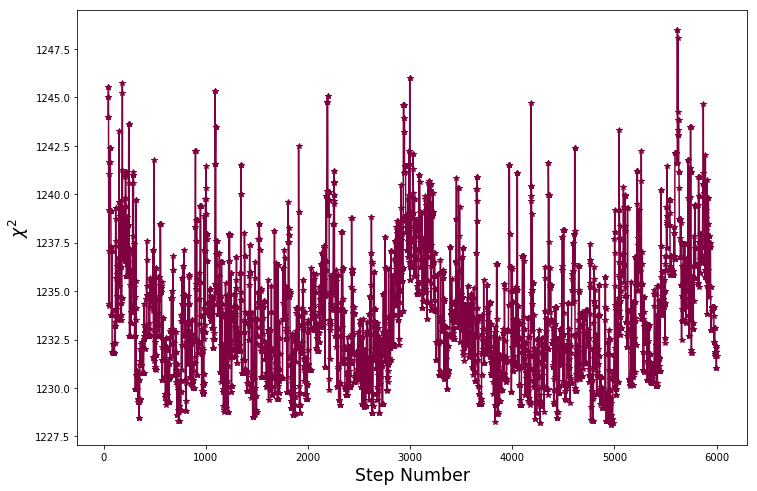

In [157]:
fn = 'chain_save.npy'
chain_trial = np.load(fn)
up_to = int(chain_trial[:,0].max())
chain_trial = chain_trial[:up_to]
start = 40
plt.plot(chain_trial[start:,0],chain_trial[start:,1],marker='*',c=c1)
plt.ylabel('$\chi^2$',fontsize='xx-large')
plt.xlabel('Step Number',fontsize='xx-large')
plt.show()

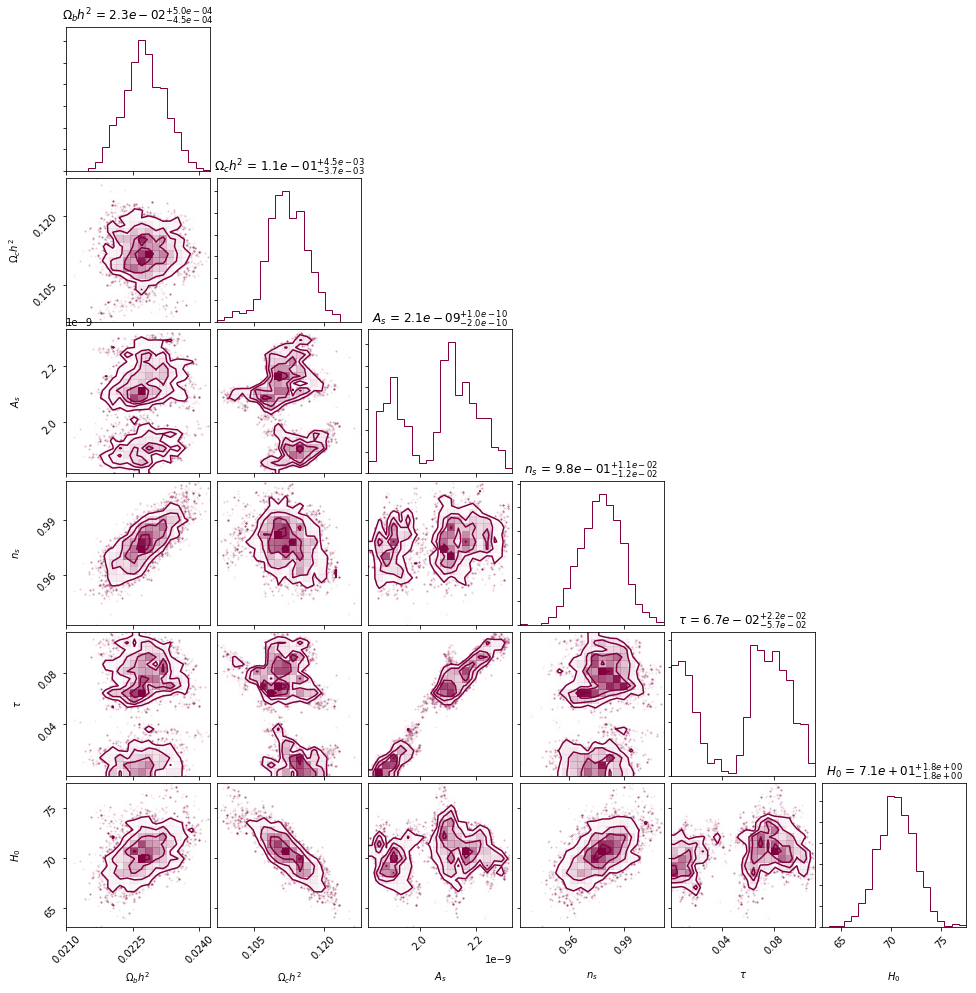

In [152]:
corner.corner(chain_trial[:,2:],color=c1,max_n_ticks=3,labels=names,show_titles=True,
              title_fmt='.1e')
plt.show()